# Bull Call Spread on Bank Nifty Data

https://zerodha.com/varsity/chapter/bull-call-spread/

In this assignment I have given the code for bull call spread on bank nifty data for 1 month managing the delta of 0.8 <br/>
Also rather than buying at the money call option, we have bought bank nifty futures at the start of the month and we will hedge it by selling OTM call option.

## Importing important libraries

In [1]:
#pip install py_vollib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# to fetch data 
import yfinance as yf

import scipy.stats as ss

import py_vollib.black_scholes.greeks.analytical as derivatives

import math

## Importing data

In [3]:
df_fut = pd.read_csv('C:/Users/ANKIT/Downloads/FUTIDX_BANKNIFTY_28-May-2021_TO_24-Jun-2021.csv')  #Fill in with the address of where you downloaded the file. You can check in properties of the file
df_fut.head()

Symbol         Date       Expiry      Open      High       Low  \
0  BANKNIFTY  28-May-2021  24-Jun-2021  35499.00  35670.00  35150.00   
1  BANKNIFTY  31-May-2021  24-Jun-2021  35280.00  35650.00  35063.15   
2  BANKNIFTY  01-Jun-2021  24-Jun-2021  35677.95  35797.45  35313.95   
3  BANKNIFTY  02-Jun-2021  24-Jun-2021  35380.00  35560.00  35180.00   
4  BANKNIFTY  03-Jun-2021  24-Jun-2021  35662.20  35890.00  35553.00   

      Close       LTP  Settle Price  No. of contracts  Turnover in Lacs  \
0  35321.80  35394.05      35321.80            151658        1340811.02   
1  35602.90  35578.25      35602.90            141916        1257088.18   
2  35454.10  35470.00      35454.10            145631        1292727.92   
3  35524.25  35540.00      35524.25            113559        1003669.30   
4  35781.95  35775.00      35781.95            121729        1086929.72   

   Open Int  Change in OI Underlying Value   
0   1745000         27775          35141.45  
1   1723450        -21550                 -  
2   1731125          7675                 -  
3   1700025        -31100                 -  
4   1690250         -9775                 -

In [4]:
df_call_36000 = pd.read_csv('C:/Users/ANKIT/Downloads/OPTIDX_BANKNIFTY_CE_28-May-2021_TO_24-Jun-2021.csv')
df_call_36000.head()

Symbol         Date       Expiry Option Type  Strike Price    Open  \
0  BANKNIFTY  28-May-2021  24-Jun-2021          CE         36000  849.95   
1  BANKNIFTY  31-May-2021  24-Jun-2021          CE         36000  693.90   
2  BANKNIFTY  01-Jun-2021  24-Jun-2021          CE         36000  782.00   
3  BANKNIFTY  02-Jun-2021  24-Jun-2021          CE         36000  575.50   
4  BANKNIFTY  03-Jun-2021  24-Jun-2021          CE         36000  659.05   

     High     Low   Close     LTP  Settle Price  No. of contracts  \
0  924.50  665.60  730.80  743.30        730.80             26704   
1  790.00  598.10  772.95  752.05        772.95             19525   
2  832.00  633.35  660.65  661.00        660.65             31536   
3  625.95  533.85  612.70  606.85        612.70             19060   
4  753.90  596.50  698.40  696.00        698.40             24549   

   Turnover in Lacs  Premium Turnover in Lacs  Open Int  Change in OI  \
0         245464.26                   5128.26    320700        116225   
1         179242.57                   3517.57    331150         10450   
2         289503.11                   5679.11    313700        -17450   
3         174293.32                   2753.32    324475         10775   
4         225062.12                   4121.12    328425          3950   

  Underlying Value  
0         35141.45  
1                -  
2                -  
3                -  
4                -

In [5]:
symbol = '^NSEBANK'
end = '2021-06-25'
start = '2021-05-28'


# Read data 
df = yf.download(symbol,start,end)

df.tail()

[*********************100%***********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2021-06-18  34735.148438  34787.398438  33908.949219  34558.000000   
2021-06-21  34109.449219  34927.648438  33937.500000  34871.300781   
2021-06-22  35084.898438  35281.898438  34664.351562  34745.000000   
2021-06-23  34911.851562  34937.648438  34525.449219  34574.000000   
2021-06-24  34687.699219  34935.300781  34592.351562  34827.000000   

               Adj Close  Volume  
Date                              
2021-06-18  34558.000000       0  
2021-06-21  34871.300781       0  
2021-06-22  34745.000000       0  
2021-06-23  34574.000000       0  
2021-06-24  34827.000000       0

### Calculation of annual volatility and time remainig for expiry used in calculation of delta

In [6]:
symbol = '^NSEBANK'
end = '2021-05-28'
start = '2020-05-28'


# Read data 
df_year = yf.download(symbol,start,end)

df_year.head()

[*********************100%***********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2020-05-28  18924.449219  19455.550781  18818.949219  19169.800781   
2020-05-29  18962.000000  19358.050781  18729.900391  19297.250000   
2020-06-01  19728.900391  20225.349609  19632.900391  19959.900391   
2020-06-02  20120.599609  20615.750000  19852.550781  20530.199219   
2020-06-03  20966.599609  21619.550781  20822.000000  20940.699219   

               Adj Close  Volume  
Date                              
2020-05-28  19169.800781  561100  
2020-05-29  19297.250000  581700  
2020-06-01  19959.900391  558100  
2020-06-02  20530.199219  448300  
2020-06-03  20940.699219  616900

In [7]:
ret = df_year['Close'].pct_change()[1:]

In [8]:
ret.head()

Date
2020-05-29    0.006648
2020-06-01    0.034339
2020-06-02    0.028572
2020-06-03    0.019995
2020-06-04   -0.026277
Name: Close, dtype: float64

In [9]:
daily_vol = ret.std()
daily_vol

0.018580334637206992

In [10]:
vol = daily_vol*252**0.5
vol

0.2949536683584554

In [11]:
expiry = datetime.strptime('2021-06-24', '%Y-%m-%d')   #Expiry date

In [12]:
time = expiry-df.index    #Time left in days
time

TimedeltaIndex(['27 days', '24 days', '23 days', '22 days', '21 days',
                '20 days', '17 days', '16 days', '15 days', '14 days',
                '13 days', '10 days',  '9 days',  '8 days',  '7 days',
                 '6 days',  '3 days',  '2 days',  '1 days',  '0 days'],
               dtype='timedelta64[ns]', name='Date', freq=None)

In [13]:
time = pd.to_timedelta(time, errors='coerce').days  #Time left in days converted to int data type
time

Int64Index([27, 24, 23, 22, 21, 20, 17, 16, 15, 14, 13, 10, 9, 8, 7, 6, 3, 2,
            1, 0],
           dtype='int64', name='Date')

### Initial buying and selling

In [14]:
no_of_lots_fut = 10           #number of future lots we bought at start of the month
buy_avg_future = df_fut['Open'][0]       #buying average of that lot
lot_size = 25     #lot size of bank nifty
delta = 1*no_of_lots_fut*lot_size    #taking delta of future is 1 as if banknifty changes by 1 the future would also change by 1
delta_to_maintain = 0.8*no_of_lots_fut*lot_size    #we will maintain 0.8 delta per future contract

In [15]:
flag = 'c'   #for call or put option
S = df['Open'][0]    #price of the underlying
K = 36000   #strike price
t = time[0]/365   #time left to expiry in years
sigma = vol   #volatility
r = 0.06  #risk free rate
delta_per_lot_call = derivatives.delta(flag, S, K, t, r, sigma)*lot_size   #to calculate delta per lot
delta_per_lot_call

11.175180281228103

In [16]:
delta_to_maintain

200.0

In [17]:
delta

250

In [18]:
number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)  #number of call lots we have to sell to keep delta of 200

In [19]:
number_of_lots_call

5

In [20]:
sell_avg_call = df_call_36000['Open'][0]  #selling avg of call 
sell_avg_call

849.95

In [21]:
# Before moving on to managing delta, answer a few questions:

#Q1 : What do you think would happen to the delta of call option as banknifty goes up? (increase/decrease) 
#Ans : increase

#Q2 : So to manage the delta what would be done to call options already sold? (Buy some call options / Sell more) 
#Hint : Remember selling call options would give negative delta
#Ans : Sell more

### Managing delta

In [22]:
number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)  #number of call lots we have to sell to keep delta of 200
sell_avg_call = df_call_36000['Open'][0]  #selling avg of call 
profit= []

for i in range(len(df)-1):
    delta_per_lot_call = derivatives.delta(flag, df['Close'][i], 36000, time[i]/365, sigma, r)*lot_size  #Calculation of delta per lot at the next closing day
    current_number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)   #number of lots required to sell
    no_of_lots_added = current_number_of_lots_call - number_of_lots_call   #number of lots added/subtracted for selling
    sell_avg_call = (sell_avg_call*number_of_lots_call + no_of_lots_added*df_call_36000['Close'][i])/current_number_of_lots_call  #new selling avg of call
    number_of_lots_call = current_number_of_lots_call    #updating number of lots of calls sold
    profit.append((df_fut['Close'][i]-buy_avg_future)*no_of_lots_fut*lot_size + (sell_avg_call-df_call_36000['Close'][i])*lot_size*number_of_lots_call)  #unrealised profit 
    #print(df_fut['Close'][i], buy_avg_future, sell_avg_call, df_call_36000['Close'][i])

In [23]:
#As you can see that the number of lots of call sold is way too many as the delta of out of money call option approches 0 in the end
#Thus this strategy would practically be possible by changing the strike price of the call option as it goes deep out of money
#But that would require much higher level programming thats why we have given this simple assignment jst theoretically make
#you realise the power of hedging
number_of_lots_call

2165495039789944117876971656575975424

In [24]:
sell_avg_call

8.1

In [25]:
delta_per_lot_call

2.3089408694674297e-35

In [26]:
profit

[-29406.24999999926,
 35600.000000000364,
 9629.999999999643,
 31962.5,
 87817.49999999927,
 30648.75000000002,
 60888.74999999927,
 -4848.749999999258,
 -51640.000000000364,
 -63847.50000000035,
 -64397.50000000034,
 -42940.00000000039,
 -78631.24999999956,
 -94838.7500000002,
 388763.7499999985,
 51099332.499999985,
 274236640.0000021,
 17428097778.619137,
 -221774.99999999965]

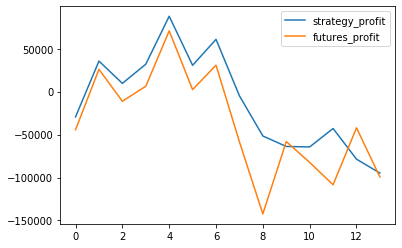

In [27]:
plt.plot(profit[:14], label = 'strategy_profit')
plt.plot((df_fut['Close']-df_fut['Open'][0])[:14]*250, label = 'futures_profit')
plt.legend()

As you can see from the above graph of first first 14 days of the strategy that though the futures did fall very down but<br/>
We were able to hedge this with selling of call option and our strategy did give better returns overall<br/>
<br/>
We didnt plot the whole graph as in the end many lots of call options were sold which is practically not possible<br/>

### Short strangle with delta hedging

https://zerodha.com/varsity/chapter/the-long-short-strangle/

Coming to the reality we can't predict market accurately and it may lead to loss.<br/>
So in practice market neutral strategies are very helpful and can give decent returns with very less risk<br/>
One such strategy is to sell put and call options such that the overall delta of our positions remains 0.

Try to code the above strategy and manage delta just like given in the previous strategy.<br/>
You will only use 35000 puts and calls for this strategy.<br/>
Initially sell 10 lots of puts and correspondingly sell x lots of calls such that the delta becomes 0.<br/>
Then manage the delta accordingly by just selling or buying call options and not changing the number of put options sold.<br/>
Also plot the profit graph on whole data and see the results!<br/>

Hint: Do remember that unlike futures which has delta of 1 delta of 35000 puts options would change everytime.

### Importing data

In [28]:
df_call_35000 = pd.read_csv('C:/Users/ANKIT/Downloads/OPTIDX_BANKNIFTY_CE_28-May-2021_TO_24-Jun-2021_1.csv')
df_call_35000.head()

Symbol         Date       Expiry Option Type  Strike Price     Open  \
0  BANKNIFTY  28-May-2021  24-Jun-2021          CE         35000  1394.65   
1  BANKNIFTY  31-May-2021  24-Jun-2021          CE         35000  1197.95   
2  BANKNIFTY  01-Jun-2021  24-Jun-2021          CE         35000  1291.90   
3  BANKNIFTY  02-Jun-2021  24-Jun-2021          CE         35000  1099.30   
4  BANKNIFTY  03-Jun-2021  24-Jun-2021          CE         35000  1163.20   

     High     Low    Close      LTP  Settle Price  No. of contracts  \
0  1459.5  1132.0  1213.55  1224.50       1213.55             18138   
1  1339.0  1021.6  1308.30  1281.95       1308.30             14456   
2  1398.0  1112.3  1155.05  1163.00       1155.05             15231   
3  1145.7   982.5  1128.05  1122.00       1128.05             12258   
4  1342.5  1111.7  1265.45  1270.00       1265.45              7511   

   Turnover in Lacs  Premium Turnover in Lacs  Open Int  Change in OI  \
0         164479.84                   5772.34    283425         39000   
1         130864.56                   4374.56    245275        -38150   
2         137967.95                   4696.70    345025         99750   
3         110507.46                   3249.96    342375         -2650   
4          68025.76                   2304.51    307825        -34550   

  Underlying Value  
0         35141.45  
1                -  
2                -  
3                -  
4                -

In [29]:
df_put_35000 = pd.read_csv('C:/Users/ANKIT/Downloads/OPTIDX_BANKNIFTY_PE_28-May-2021_TO_24-Jun-2021.csv')
df_put_35000.tail()

Symbol         Date       Expiry Option Type  Strike Price    Open  \
15  BANKNIFTY  18-Jun-2021  24-Jun-2021          PE         35000  490.00   
16  BANKNIFTY  21-Jun-2021  24-Jun-2021          PE         35000  716.25   
17  BANKNIFTY  22-Jun-2021  24-Jun-2021          PE         35000  187.75   
18  BANKNIFTY  23-Jun-2021  24-Jun-2021          PE         35000  319.00   
19  BANKNIFTY  24-Jun-2021  24-Jun-2021          PE         35000  440.00   

       High     Low   Close     LTP  Settle Price  No. of contracts  \
15  1209.65  466.50  591.40  486.15        591.40            134605   
16  1099.95  311.70  338.90  329.00        338.90            134434   
17   409.75  134.10  363.05  380.00        363.05           1988272   
18   490.00  225.35  441.75  439.10        441.75            994679   
19   466.95   85.00  178.25  172.60      34827.00           1353795   

    Turnover in Lacs  Premium Turnover in Lacs  Open Int  Change in OI  \
15        1201978.49                  24184.74    388175        -42950   
16        1192854.25                  16556.75    439150         50975   
17       17510021.78                 112641.78   1066050        626900   
18        8788636.49                  85195.24   1352200        286150   
19       11915053.17                  69346.92    242850      -1109350   

   Underlying Value  
15            34558  
16                -  
17                -  
18            34574  
19            34827

### Initialising everything required to calculate delta

In [30]:
#Assume we are starting the strategy at the opening time of 28th May
S = df['Close'][0]    #price of the underlying
K = 35000   #strike price
t = time[0]/365   #time left to expiry in years
sigma = vol   #volatility
r = 0.06  #risk free rate
delta_to_maintain = 0

### Initial selling

In [31]:
no_of_lots_put = 10      #number of lots of put sold
sell_avg_put = df_put_35000['Open'][0]   #selling average of seeling those lots
lot_size = 25
delta = derivatives.delta('p', S, K, t, r, sigma)*no_of_lots_put*lot_size  #total delta after selling 250 quantities of put

In [32]:
delta

-110.51841430345758

In [33]:
delta_per_lot_call = derivatives.delta('c', df['Open'][0], K, t, r, sigma)*lot_size  #delta per lot of call,i.e, delta of 25 quantities
delta_per_lot_call

14.656538354277082

In [34]:
number_of_lots_call =  math.ceil((delta_to_maintain-delta)/delta_per_lot_call)   #number of lots of call to be sold
number_of_lots_call

8

In [35]:
sell_avg_call = df_call_35000['Open'][0]   #selling average of that call options sold
sell_avg_call

1394.65

In [36]:
#Before delta management ans few questions:

#Q1. If market moves up, what would happen to delta of put options? (increase/decrease)
#Ans : decrease

#Q2. If market moves up, what would happen to delta of call options? (increase/decrease)
#Ans : increase

#Q3. What would be your ideal strategy in terms of buying/selling call options if market moves up to maintain a delta of 0.
#Ans : long strangle

'''
Bonus Question: Assume that you have set a limit to selling of your quantities and you have reached that limit of yours.
Now the market went up. You have to manage your delta such that the final quantity sold by you remains the same.
What would you do?
Hint : Think about changing the strikes of options

Ans : sell at higher strike price
'''

'\nBonus Question: Assume that you have set a limit to selling of your quantities and you have reached that limit of yours.\nNow the market went up. You have to manage your delta such that the final quantity sold by you remains the same.\nWhat would you do?\nHint : Think about changing the strikes of options\n\nAns : sell at higher strike price\n'

### Delta Management

In [37]:
number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)  #number of call lots we have to sell to keep delta of 200
sell_avg_call = df_call_35000['Open'][0]
sum1 = 0
profit = []

for i in range(len(df)-1):
    delta = derivatives.delta('p', df['Close'][i], 35000, time[i]/365, r, sigma)*no_of_lots_put*lot_size
    delta_per_lot_call = derivatives.delta('c', df['Close'][i], 35000, time[i]/365, r, sigma)*lot_size  #Calculation of delta per lot at the next closing day
    current_number_of_lots_call = math.ceil((-delta+delta_to_maintain)/delta_per_lot_call)   #number of lots required to sell
    no_of_lots_added = current_number_of_lots_call - number_of_lots_call   #number of lots added/subtracted for selling
    sell_avg_call = (sell_avg_call*number_of_lots_call + no_of_lots_added*df_call_35000['Close'][i])/current_number_of_lots_call  #new selling avg of call
    number_of_lots_call = current_number_of_lots_call    #updating number of lots of calls sold
    profit.append(194682.50000000017+(-df_put_35000['Close'][i]+sell_avg_put)*no_of_lots_put*lot_size + (sell_avg_call-df_call_35000['Close'][i])*lot_size*number_of_lots_call)
#Write the code for delta management

In [38]:
profit.append(194682.50000000017+(-df_put_35000['Close'][19]+sell_avg_put)*no_of_lots_put*lot_size + (sell_avg_call-df_call_35000['Close'][19])*lot_size*number_of_lots_call)  #profit at the expiry as at expiry delta is not done and therefore cannot be calculated in the above loop

In [39]:
profit 

[171202.50000000015,
 202440.00000000015,
 230546.25000000015,
 260871.25000000015,
 266001.2500000001,
 282106.2500000002,
 300708.7500000002,
 330953.7500000002,
 339150.0000000001,
 341805.0000000001,
 366710.0000000001,
 394226.2500000001,
 401351.2500000001,
 407921.2500000001,
 429846.2500000001,
 459340.0000000001,
 496725.0000000001,
 518332.5000000001,
 543218.7500000001,
 649593.7500000001]

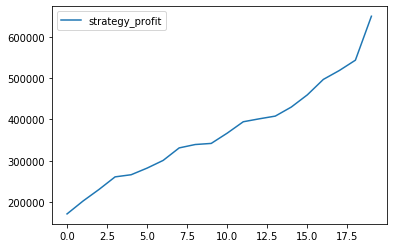

In [40]:
#Plot the profit graph
plt.plot(profit[:], label = 'strategy_profit')
plt.legend()

See the results you get by selling calls and puts and just managing delta at end of day